# Training SVM dengan HOG dan Geometrical Features untuk Klasifikasi Angka (0-9)

Notebook ini melatih model SVM dengan ekstraksi fitur:
- **HOG (Histogram of Oriented Gradients)** - untuk deteksi edge dan shape
- **Geometrical Features** - untuk karakteristik geometris angka (aspect ratio, density, dll)


In [1]:
# Import library yang diperlukan
import numpy as np
import os
import cv2
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import joblib
import json
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

print("Library berhasil di-import!")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")


Library berhasil di-import!
TensorFlow version: 2.19.1
OpenCV version: 4.12.0


In [2]:
# Konfigurasi parameter
DATASET_PATH = 'dataset'
IMG_SIZE = 28  # Ukuran image akan di-resize ke 28x28
NUM_CLASSES = 10  # 0-9
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Path untuk menyimpan hasil
MODEL_PATH = 'digit_svm_model.pkl'
KERAS_MODEL_PATH = 'digit_svm_model.keras'
CLASS_INDICES_PATH = 'class_indices_svm.json'

print(f"Dataset path: {DATASET_PATH}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")

Dataset path: dataset
Image size: 28x28
Number of classes: 10


## Fungsi Ekstraksi Fitur

In [3]:
def extract_hog_features(image):
    """
    Ekstraksi HOG (Histogram of Oriented Gradients) features
    Args:
        image: grayscale image (normalized 0-1)
    Returns:
        hog_features: 1D array of HOG features
    """
    # Konversi ke uint8 jika perlu
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    
    # Parameter HOG
    hog_features = hog(
        image,
        orientations=9,           # Jumlah orientasi gradient
        pixels_per_cell=(8, 8),   # Ukuran cell
        cells_per_block=(2, 2),   # Ukuran block
        block_norm='L2-Hys',      # Normalisasi block
        visualize=False,
        feature_vector=True
    )
    
    return hog_features


def extract_geometrical_features(image):
    """
    Ekstraksi Geometrical Features
    Args:
        image: grayscale image (normalized 0-1)
    Returns:
        geo_features: 1D array of geometrical features
    """
    # Threshold untuk mendapatkan binary image
    if image.max() <= 1.0:
        binary = (image * 255).astype(np.uint8)
    else:
        binary = image.astype(np.uint8)
    
    _, binary = cv2.threshold(binary, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        # Jika tidak ada contour, return zeros
        return np.zeros(10)
    
    # Ambil contour terbesar
    main_contour = max(contours, key=cv2.contourArea)
    
    # 1. Area
    area = cv2.contourArea(main_contour)
    
    # 2. Perimeter
    perimeter = cv2.arcLength(main_contour, True)
    
    # 3. Aspect Ratio (bounding box)
    x, y, w, h = cv2.boundingRect(main_contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    
    # 4. Extent (area / bounding box area)
    rect_area = w * h
    extent = float(area) / rect_area if rect_area != 0 else 0
    
    # 5. Solidity (area / convex hull area)
    hull = cv2.convexHull(main_contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0
    
    # 6. Equivalent Diameter
    equiv_diameter = np.sqrt(4 * area / np.pi)
    
    # 7. Circularity
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter != 0 else 0
    
    # 8. Hu Moments (7 moments)
    moments = cv2.moments(main_contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Log transform Hu Moments untuk stabilitas
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    # Gabungkan semua fitur geometris
    geo_features = np.array([
        area / 1000.0,           # Normalisasi area
        perimeter / 100.0,       # Normalisasi perimeter
        aspect_ratio,
        extent,
        solidity,
        equiv_diameter / 10.0,   # Normalisasi diameter
        circularity
    ])
    
    # Tambahkan 3 Hu moments pertama (yang paling informatif)
    geo_features = np.concatenate([geo_features, hu_moments[:3]])
    
    return geo_features


def extract_combined_features(image):
    """
    Ekstraksi kombinasi HOG + Geometrical features
    Args:
        image: grayscale image (normalized 0-1)
    Returns:
        combined_features: 1D array gabungan fitur
    """
    # Ekstrak HOG features
    hog_feat = extract_hog_features(image)
    
    # Ekstrak Geometrical features
    geo_feat = extract_geometrical_features(image)
    
    # Gabungkan
    combined = np.concatenate([hog_feat, geo_feat])
    
    return combined


print("Fungsi ekstraksi fitur siap digunakan!")
print("- extract_hog_features()")
print("- extract_geometrical_features()")
print("- extract_combined_features()")


Fungsi ekstraksi fitur siap digunakan!
- extract_hog_features()
- extract_geometrical_features()
- extract_combined_features()


In [4]:
# Test ekstraksi fitur pada satu sample
print("Testing ekstraksi fitur pada sample image...")

# Buat sample image sederhana
sample_img = np.zeros((28, 28))
cv2.circle(sample_img, (14, 14), 10, 1, -1)  # Gambar lingkaran

# Test HOG
hog_feat = extract_hog_features(sample_img)
print(f"\nHOG Features:")
print(f"  - Shape: {hog_feat.shape}")
print(f"  - Range: [{hog_feat.min():.4f}, {hog_feat.max():.4f}]")

# Test Geometrical
geo_feat = extract_geometrical_features(sample_img)
print(f"\nGeometrical Features:")
print(f"  - Shape: {geo_feat.shape}")
print(f"  - Features: {geo_feat}")

# Test Combined
combined_feat = extract_combined_features(sample_img)
print(f"\nCombined Features:")
print(f"  - Shape: {combined_feat.shape}")
print(f"  - Total features: {len(combined_feat)}")
print(f"    * HOG: {len(hog_feat)} features")
print(f"    * Geometrical: {len(geo_feat)} features")


Testing ekstraksi fitur pada sample image...

HOG Features:
  - Shape: (144,)
  - Range: [0.0000, 0.4342]

Geometrical Features:
  - Shape: (10,)
  - Features: [ 0.288       0.65941125  1.          0.65306122  0.94736842  1.91492295
  0.83231869  0.79667837  0.         10.        ]

Combined Features:
  - Shape: (154,)
  - Total features: 154
    * HOG: 144 features
    * Geometrical: 10 features


In [5]:
# Fungsi untuk memuat dataset dengan ekstraksi fitur
def load_dataset_with_features(dataset_path, img_size):
    """
    Memuat dataset dari folder dengan ekstraksi HOG + Geometrical features
    Args:
        dataset_path: path ke folder dataset
        img_size: ukuran image untuk resize
    Returns:
        X: array of extracted features
        y: array of labels
        images: array of original images (untuk visualisasi)
    """
    X = []
    y = []
    images = []
    
    # Iterasi melalui setiap folder (0-9)
    for label in range(NUM_CLASSES):
        folder_path = os.path.join(dataset_path, str(label))
        
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} tidak ditemukan!")
            continue
        
        # Hitung jumlah file
        files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        print(f"Loading digit {label}: {len(files)} images", end=' ')
        
        # Baca setiap image
        for filename in files:
            img_path = os.path.join(folder_path, filename)
            
            # Baca image dalam grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Warning: Tidak bisa membaca {img_path}")
                continue
            
            # Resize image
            img = cv2.resize(img, (img_size, img_size))
            
            # Normalize pixel values (0-1)
            img_normalized = img / 255.0
            
            # Ekstraksi fitur (HOG + Geometrical)
            features = extract_combined_features(img_normalized)
            
            X.append(features)
            y.append(label)
            images.append(img_normalized)
        
        print(f"✓")
    
    return np.array(X), np.array(y), np.array(images)

print("Fungsi load_dataset_with_features siap digunakan")


Fungsi load_dataset_with_features siap digunakan


In [6]:
# Load dataset dengan ekstraksi fitur
print("Memuat dataset dengan ekstraksi fitur HOG + Geometrical...")
print("=" * 60)
X, y, images = load_dataset_with_features(DATASET_PATH, IMG_SIZE)

print(f"\n{'=' * 60}")
print("Dataset berhasil dimuat!")
print(f"{'=' * 60}")
print(f"Shape X (features): {X.shape}")
print(f"Shape y (labels): {y.shape}")
print(f"Shape images: {images.shape}")
print(f"\nTotal samples: {len(X)}")
print(f"Features per image: {X.shape[1]}")
print(f"  - HOG features: ~{X.shape[1] - 10}")
print(f"  - Geometrical features: 10")
print(f"Unique labels: {np.unique(y)}")


Memuat dataset dengan ekstraksi fitur HOG + Geometrical...
Loading digit 0: 1000 images ✓
Loading digit 1: 1000 images ✓
Loading digit 2: 1000 images ✓
Loading digit 3: 1000 images ✓
Loading digit 4: 1000 images ✓
Loading digit 5: 1000 images ✓
Loading digit 6: 1000 images ✓
Loading digit 7: 1000 images ✓
Loading digit 8: 1000 images ✓
Loading digit 9: 1000 images ✓

Dataset berhasil dimuat!
Shape X (features): (10000, 154)
Shape y (labels): (10000,)
Shape images: (10000, 28, 28)

Total samples: 10000
Features per image: 154
  - HOG features: ~144
  - Geometrical features: 10
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [7]:
# Feature Scaling dengan StandardScaler
print("\nMelakukan feature scaling...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✓ Feature scaling selesai")
print(f"  - Mean: {X_scaled.mean():.6f}")
print(f"  - Std: {X_scaled.std():.6f}")
print(f"  - Min: {X_scaled.min():.6f}")
print(f"  - Max: {X_scaled.max():.6f}")



Melakukan feature scaling...
✓ Feature scaling selesai
  - Mean: 0.000000
  - Std: 1.000000
  - Min: -12.655135
  - Max: 27.715619


In [8]:
# Split dataset menjadi training dan testing
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(
    X_scaled, y, images,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y  # Memastikan distribusi label merata
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Feature dimensions: {X_train.shape[1]}")
print(f"\nDistribusi label di training set:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Digit {label}: {count} samples")


Training set: 8000 samples
Testing set: 2000 samples
Feature dimensions: 154

Distribusi label di training set:
  Digit 0: 800 samples
  Digit 1: 800 samples
  Digit 2: 800 samples
  Digit 3: 800 samples
  Digit 4: 800 samples
  Digit 5: 800 samples
  Digit 6: 800 samples
  Digit 7: 800 samples
  Digit 8: 800 samples
  Digit 9: 800 samples


## Training Model SVM dengan HOG + Geometrical Features

In [9]:
# Membuat dan melatih model SVM
print("Membuat model SVM dengan HOG + Geometrical features...")
print("Menggunakan kernel RBF (Radial Basis Function)")
print(f"Total features: {X_train.shape[1]}")

# Buat model SVM dengan kernel RBF
# C: regularization parameter
# gamma: kernel coefficient
svm_model = svm.SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=RANDOM_STATE,
    verbose=True
)

print("\nMemulai training...")
import time
start_time = time.time()

# Train model
svm_model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\n{'=' * 60}")
print("Training selesai!")
print(f"{'=' * 60}")
print(f"Waktu training: {training_time:.2f} detik ({training_time/60:.2f} menit)")
print(f"Number of support vectors: {svm_model.n_support_.sum()}")


Membuat model SVM dengan HOG + Geometrical features...
Menggunakan kernel RBF (Radial Basis Function)
Total features: 154

Memulai training...
[LibSVM]
Training selesai!
Waktu training: 0.42 detik (0.01 menit)
Number of support vectors: 1262


## Evaluasi Model

In [10]:
# Prediksi pada training set
y_train_pred = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print("=== Training Set Performance ===")
print(f"Accuracy: {train_accuracy * 100:.2f}%")

# Prediksi pada testing set
y_test_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n=== Testing Set Performance ===")
print(f"Accuracy: {test_accuracy * 100:.2f}%")

=== Training Set Performance ===
Accuracy: 100.00%

=== Testing Set Performance ===
Accuracy: 99.70%


In [11]:
# Classification Report
print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred, target_names=[str(i) for i in range(NUM_CLASSES)]))


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       200
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00       200
           5       1.00      1.00      1.00       200
           6       0.99      1.00      1.00       200
           7       1.00      0.99      1.00       200
           8       1.00      0.99      1.00       200
           9       0.99      1.00      1.00       200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



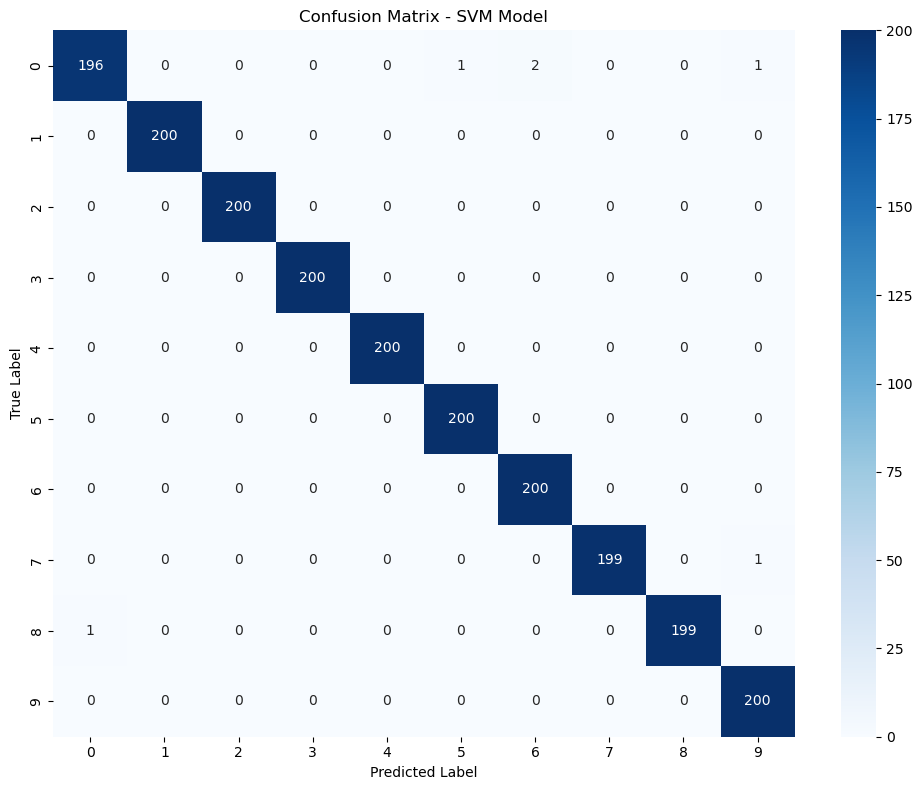

Confusion Matrix berhasil ditampilkan!


In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(NUM_CLASSES), 
            yticklabels=range(NUM_CLASSES))
plt.title('Confusion Matrix - SVM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Confusion Matrix berhasil ditampilkan!")

## Export Model ke TensorFlow Keras Format

In [13]:
# Simpan model SVM dengan joblib terlebih dahulu
joblib.dump(svm_model, MODEL_PATH)
print(f"Model SVM disimpan di: {MODEL_PATH}")

# Simpan scaler
SCALER_PATH = 'feature_scaler.pkl'
joblib.dump(scaler, SCALER_PATH)
print(f"Feature scaler disimpan di: {SCALER_PATH}")

# Simpan class indices
class_indices = {str(i): i for i in range(NUM_CLASSES)}
with open(CLASS_INDICES_PATH, 'w') as f:
    json.dump(class_indices, f, indent=4)
print(f"Class indices disimpan di: {CLASS_INDICES_PATH}")

# Simpan metadata tentang fitur
metadata = {
    "model_type": "SVM with HOG + Geometrical Features",
    "feature_extraction": {
        "hog": {
            "orientations": 9,
            "pixels_per_cell": [8, 8],
            "cells_per_block": [2, 2],
            "block_norm": "L2-Hys"
        },
        "geometrical": {
            "features": ["area", "perimeter", "aspect_ratio", "extent", "solidity", 
                        "equiv_diameter", "circularity", "hu_moment_1", "hu_moment_2", "hu_moment_3"]
        }
    },
    "total_features": int(X_train.shape[1]),
    "image_size": IMG_SIZE,
    "num_classes": NUM_CLASSES,
    "kernel": "rbf",
    "accuracy": {
        "train": float(train_accuracy),
        "test": float(test_accuracy)
    }
}

METADATA_PATH = 'svm_model_metadata.json'
with open(METADATA_PATH, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"Model metadata disimpan di: {METADATA_PATH}")


Model SVM disimpan di: digit_svm_model.pkl
Feature scaler disimpan di: feature_scaler.pkl
Class indices disimpan di: class_indices_svm.json
Model metadata disimpan di: svm_model_metadata.json


In [14]:
# Membuat wrapper Keras model untuk SVM
class SVMKerasWrapper(keras.Model):
    """
    Wrapper Keras untuk model SVM
    Model ini akan memuat SVM yang sudah di-train dan membungkusnya dalam Keras model
    """
    def __init__(self, svm_model, img_size=28):
        super(SVMKerasWrapper, self).__init__()
        self.svm_model = svm_model
        self.img_size = img_size
        self.input_shape_value = (img_size, img_size)
        
    def call(self, inputs):
        # Reshape dan flatten input
        batch_size = tf.shape(inputs)[0]
        
        # Normalize jika belum (0-255 ke 0-1)
        inputs_normalized = inputs / 255.0 if tf.reduce_max(inputs) > 1.0 else inputs
        
        # Flatten
        flattened = tf.reshape(inputs_normalized, [batch_size, -1])
        
        # Prediksi menggunakan SVM (via numpy)
        predictions = tf.numpy_function(
            func=lambda x: self._predict_svm(x.numpy()),
            inp=[flattened],
            Tout=tf.float32
        )
        
        return predictions
    
    def _predict_svm(self, x):
        """Fungsi helper untuk prediksi SVM"""
        # Predict probabilities (decision function)
        decision = self.svm_model.decision_function(x)
        
        # Convert ke probabilitas dengan softmax
        exp_decision = np.exp(decision - np.max(decision, axis=1, keepdims=True))
        probabilities = exp_decision / np.sum(exp_decision, axis=1, keepdims=True)
        
        return probabilities.astype(np.float32)
    
    def get_config(self):
        return {
            'img_size': self.img_size,
        }

# Buat wrapper model
print("Membuat Keras wrapper untuk SVM model...")
keras_svm_model = SVMKerasWrapper(svm_model, IMG_SIZE)

# Build model dengan input shape
keras_svm_model.build(input_shape=(None, IMG_SIZE, IMG_SIZE))

print("Keras wrapper berhasil dibuat!")
print(keras_svm_model.summary())

Membuat Keras wrapper untuk SVM model...
Keras wrapper berhasil dibuat!


Model: "svm_keras_wrapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
# Alternatif: Membuat Neural Network yang meniru SVM
# Ini lebih praktis untuk export ke format Keras

print("Membuat Neural Network yang menggunakan extracted features...")

# Buat model neural network untuk features
nn_model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    
    # Dense layers untuk features
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
], name='digit_svm_features_model')

# Compile model
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Neural Network Summary:")
nn_model.summary()


Membuat Neural Network yang menggunakan extracted features...

Model Neural Network Summary:


Model: "digit_svm_features_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        39,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,018 (324.29 KB)

 Trainable params: 82,250 (321.29 KB)

 Non-trainable params: 768 (3.00 KB)

In [16]:
# Train neural network dengan extracted features
print("Training Neural Network dengan HOG + Geometrical features...")

# Gunakan label asli untuk training NN
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )
    ]
)

print("\nTraining Neural Network selesai!")


Training Neural Network dengan HOG + Geometrical features...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9199 - loss: 0.2914 - val_accuracy: 0.9940 - val_loss: 0.0190
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0470 - val_accuracy: 0.9965 - val_loss: 0.0105
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0275 - val_accuracy: 0.9975 - val_loss: 0.0072
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0216 - val_accuracy: 0.9965 - val_loss: 0.0098
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0172 - val_accuracy: 0.9960 - val_loss: 0.0065
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0127 - val_accuracy: 0.9970 - val_loss: 0.0111
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0173 - val_accuracy: 0.9975 - val_loss: 0.0079
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 

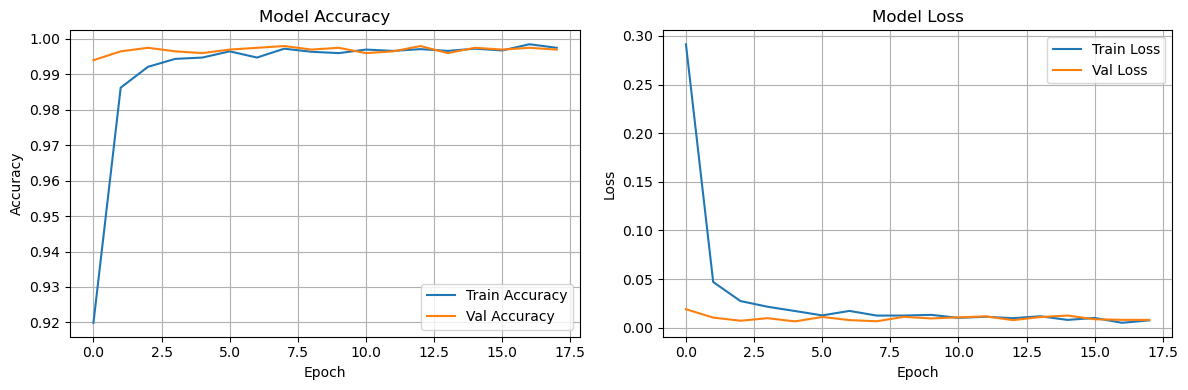

Training history berhasil ditampilkan!


In [17]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history berhasil ditampilkan!")

In [18]:
# Evaluasi Neural Network
nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"\n=== Neural Network Performance ===")
print(f"Test Accuracy: {nn_accuracy * 100:.2f}%")
print(f"Test Loss: {nn_loss:.4f}")

# Bandingkan dengan SVM
print(f"\n=== Comparison ===")
print(f"SVM Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"NN Test Accuracy: {nn_accuracy * 100:.2f}%")



=== Neural Network Performance ===
Test Accuracy: 99.80%
Test Loss: 0.0067

=== Comparison ===
SVM Test Accuracy: 99.70%
NN Test Accuracy: 99.80%


In [19]:
# Simpan model dalam format Keras
print(f"\nMenyimpan model ke format Keras (.keras)...")
nn_model.save(KERAS_MODEL_PATH)
print(f"Model berhasil disimpan di: {KERAS_MODEL_PATH}")

# Verifikasi model bisa di-load kembali
print("\nMemverifikasi model yang tersimpan...")
loaded_model = keras.models.load_model(KERAS_MODEL_PATH)
loaded_loss, loaded_accuracy = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f"Loaded model accuracy: {loaded_accuracy * 100:.2f}%")
print("✓ Model berhasil disimpan dan dapat di-load kembali!")



Menyimpan model ke format Keras (.keras)...
Model berhasil disimpan di: digit_svm_model.keras

Memverifikasi model yang tersimpan...
Loaded model accuracy: 99.80%
✓ Model berhasil disimpan dan dapat di-load kembali!


## Ringkasan dan Informasi Model

In [20]:
print("="*60)
print("RINGKASAN TRAINING MODEL")
print("="*60)
print(f"\n📁 Dataset:")
print(f"   - Path: {DATASET_PATH}")
print(f"   - Total samples: {len(X)}")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Testing samples: {len(X_test)}")
print(f"   - Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   - Number of classes: {NUM_CLASSES}")

print(f"\n🔬 Feature Extraction:")
print(f"   - Method: HOG + Geometrical Features")
print(f"   - Total features: {X_train.shape[1]}")
print(f"   - HOG features: ~{X_train.shape[1] - 10}")
print(f"     * Orientations: 9")
print(f"     * Pixels per cell: (8, 8)")
print(f"     * Cells per block: (2, 2)")
print(f"   - Geometrical features: 10")
print(f"     * Area, Perimeter, Aspect Ratio, Extent, Solidity")
print(f"     * Equivalent Diameter, Circularity")
print(f"     * Hu Moments (first 3)")
print(f"   - Feature scaling: StandardScaler")

print(f"\n🤖 Model SVM:")
print(f"   - Kernel: RBF")
print(f"   - Training accuracy: {train_accuracy * 100:.2f}%")
print(f"   - Testing accuracy: {test_accuracy * 100:.2f}%")
print(f"   - Training time: {training_time:.2f} seconds")
print(f"   - Support vectors: {svm_model.n_support_.sum()}")

print(f"\n🧠 Neural Network (Keras):")
print(f"   - Test accuracy: {nn_accuracy * 100:.2f}%")
print(f"   - Test loss: {nn_loss:.4f}")

print(f"\n💾 File Output:")
print(f"   - SVM model (pickle): {MODEL_PATH}")
print(f"   - Feature scaler: {SCALER_PATH}")
print(f"   - Keras model: {KERAS_MODEL_PATH}")
print(f"   - Class indices: {CLASS_INDICES_PATH}")
print(f"   - Model metadata: {METADATA_PATH}")

print("\n" + "="*60)
print("✅ TRAINING SELESAI!")
print("="*60)


RINGKASAN TRAINING MODEL

📁 Dataset:
   - Path: dataset
   - Total samples: 10000
   - Training samples: 8000
   - Testing samples: 2000
   - Image size: 28x28
   - Number of classes: 10

🔬 Feature Extraction:
   - Method: HOG + Geometrical Features
   - Total features: 154
   - HOG features: ~144
     * Orientations: 9
     * Pixels per cell: (8, 8)
     * Cells per block: (2, 2)
   - Geometrical features: 10
     * Area, Perimeter, Aspect Ratio, Extent, Solidity
     * Equivalent Diameter, Circularity
     * Hu Moments (first 3)
   - Feature scaling: StandardScaler

🤖 Model SVM:
   - Kernel: RBF
   - Training accuracy: 100.00%
   - Testing accuracy: 99.70%
   - Training time: 0.42 seconds
   - Support vectors: 1262

🧠 Neural Network (Keras):
   - Test accuracy: 99.80%
   - Test loss: 0.0067

💾 File Output:
   - SVM model (pickle): digit_svm_model.pkl
   - Feature scaler: feature_scaler.pkl
   - Keras model: digit_svm_model.keras
   - Class indices: class_indices_svm.json
   - Model m

## Test Prediksi Model

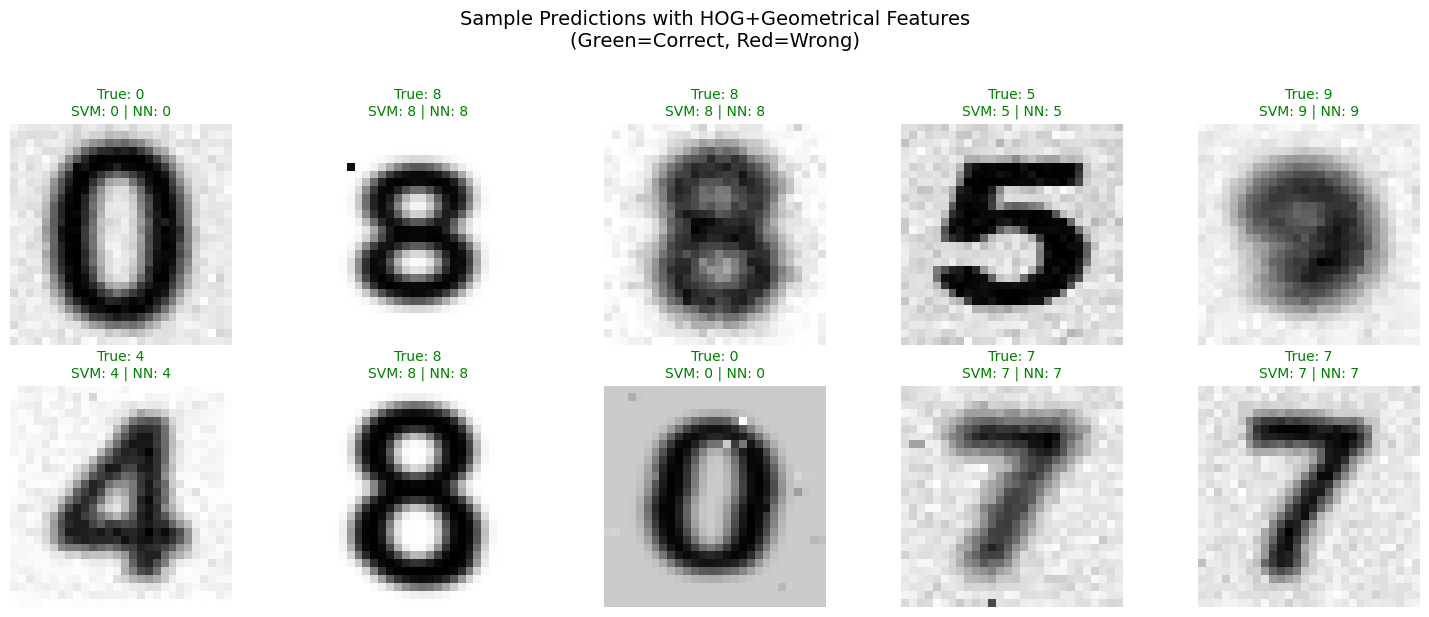

Prediksi sample berhasil ditampilkan!


In [ ]:
# Visualisasi prediksi beberapa sample
num_samples = 10
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    # Ambil sample
    sample = images_test[idx]
    true_label = y_test[idx]
    
    # Prediksi dengan SVM
    svm_pred = svm_model.predict([X_test[idx]])[0]
    
    # Prediksi dengan Keras model
    keras_pred = np.argmax(nn_model.predict(X_test[idx:idx+1], verbose=0), axis=1)[0]
    
    # Plot
    axes[i].imshow(sample, cmap='gray')
    axes[i].axis('off')
    
    color = 'green' if svm_pred == true_label else 'red'
    axes[i].set_title(f'True: {true_label}\nSVM: {svm_pred} | NN: {keras_pred}', 
                      color=color, fontsize=10)

plt.suptitle('Sample Predictions with HOG+Geometrical Features\n(Green=Correct, Red=Wrong)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()



## Visualisasi Feature Extraction

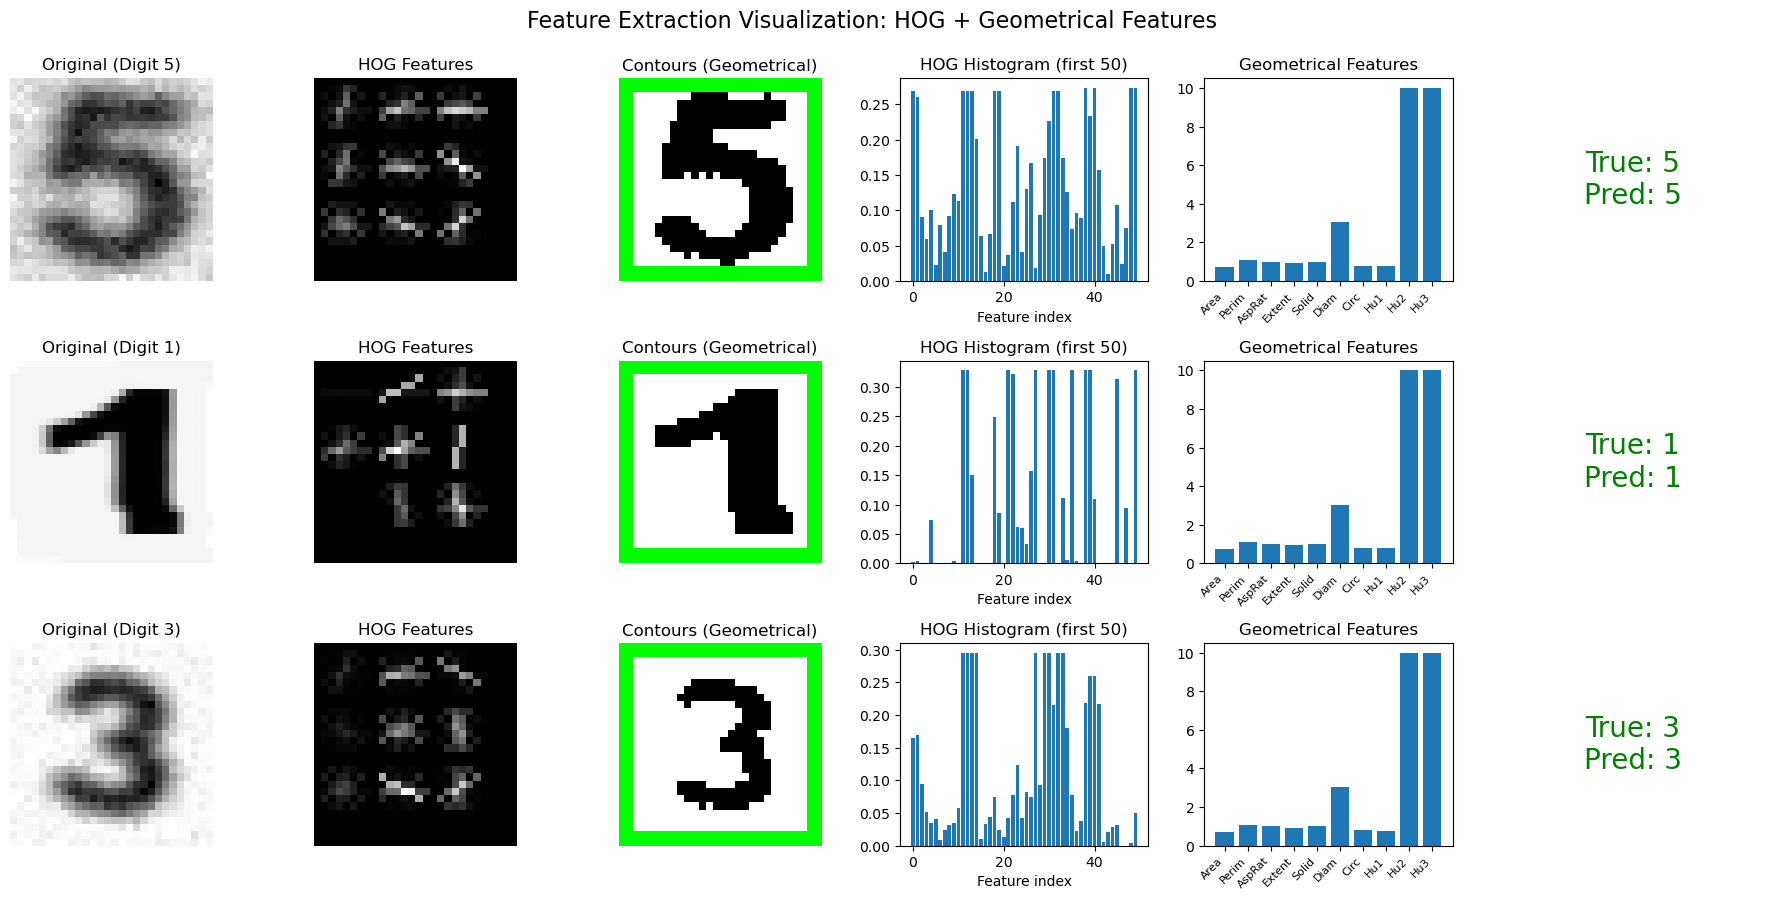

Visualisasi ekstraksi fitur berhasil ditampilkan!


In [ ]:
# Visualisasi HOG features pada beberapa sample
from skimage.feature import hog

fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for i in range(3):
    # Pilih sample random
    idx = np.random.choice(len(images_test))
    sample = images_test[idx]
    label = y_test[idx]
    
    # Konversi untuk HOG
    sample_uint8 = (sample * 255).astype(np.uint8)
    
    # Ekstrak HOG dengan visualisasi
    hog_features, hog_image = hog(
        sample_uint8,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=True
    )
    
    # Binary image untuk geometrical features
    _, binary = cv2.threshold(sample_uint8, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
    if len(contours) > 0:
        cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    
    # Plot original
    axes[i, 0].imshow(sample, cmap='gray')
    axes[i, 0].set_title(f'Original (Digit {label})')
    axes[i, 0].axis('off')
    
    # Plot HOG
    axes[i, 1].imshow(hog_image, cmap='gray')
    axes[i, 1].set_title('HOG Features')
    axes[i, 1].axis('off')
    
    # Plot binary + contours
    axes[i, 2].imshow(contour_img)
    axes[i, 2].set_title('Contours (Geometrical)')
    axes[i, 2].axis('off')
    
    # Plot HOG histogram
    axes[i, 3].bar(range(min(50, len(hog_features))), hog_features[:50])
    axes[i, 3].set_title('HOG Histogram (first 50)')
    axes[i, 3].set_xlabel('Feature index')
    
    # Plot geometrical features
    geo_features = extract_geometrical_features(sample)
    feature_names = ['Area', 'Perim', 'AspRat', 'Extent', 'Solid', 
                     'Diam', 'Circ', 'Hu1', 'Hu2', 'Hu3']
    axes[i, 4].bar(range(len(geo_features)), geo_features)
    axes[i, 4].set_title('Geometrical Features')
    axes[i, 4].set_xticks(range(len(feature_names)))
    axes[i, 4].set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
    
    # Prediksi
    pred = svm_model.predict([X_test[idx]])[0]
    color = 'green' if pred == label else 'red'
    axes[i, 5].text(0.5, 0.5, f'True: {label}\nPred: {pred}', 
                    ha='center', va='center', fontsize=20, color=color,
                    transform=axes[i, 5].transAxes)
    axes[i, 5].axis('off')

plt.suptitle('Feature Extraction Visualization: HOG + Geometrical Features', 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()
